# Imports

In [1]:
import os


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mount drive and move dataset to runtime

In [2]:
# drive.mount('/content/drive')
# runtime_dir = "/content"
data_dir = "D:\\code\\train"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read Dataset

In [4]:
train_dir = os.path.join(data_dir)

preprocessing_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def get_dataloader(img_folder, transformation, batch_size, num_workers):
    dataset = datasets.ImageFolder(root=img_folder, transform=transformation)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
dataloader_8 = get_dataloader(train_dir, preprocessing_transformation, batch_size=8, num_workers=2)

# Visualize data loader

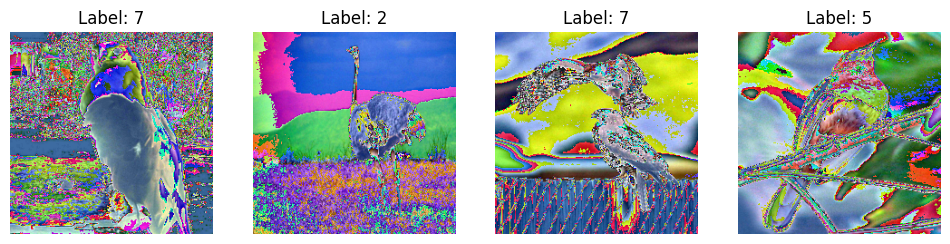

In [7]:
images, labels = next(iter(dataloader_8))
images = images.numpy()

plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow((np.transpose(images[i], (1, 2, 0)) * 255).astype(np.uint8))
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

# Define the model

In [8]:
class CustomVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGG, self).__init__()
        
        # Define the feature extractor part of VGG16
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Define the classifier part of VGG16
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = CustomVGG()
rand_input = torch.randn(8, 3, 224, 224)
output_shape = model(rand_input).shape
print(output_shape)

torch.Size([8, 10])


# Instantiate baseline model and save it for future reuse

In [10]:
def save_model(model, model_name, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [11]:
drive_dir = "D:\\code"
baseline_model = CustomVGG()
baseline_model_save_dir = os.path.join(drive_dir, "baseline_models")
baseline_model_name = "custom_vgg_init_v1"
save_model(baseline_model, baseline_model_name, baseline_model_save_dir)

Model saved to D:\code\baseline_models\custom_vgg_init_v1


# Load baseline init model

In [12]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")

In [13]:
model_path = os.path.join(drive_dir, "baseline_models", "custom_vgg_init_v1")

In [14]:
loaded_model = CustomVGG()
load_model(loaded_model, model_path)

Model loaded from D:\code\baseline_models\custom_vgg_init_v1


In [15]:
model = loaded_model
rand_input = torch.randn(8, 3, 224, 224)
output_shape = model(rand_input).shape
print(output_shape)

torch.Size([8, 10])


# Lightning Module

In [16]:
!pip install lightning

In [17]:
import lightning as pl
from torchmetrics import Metric

In [18]:
class vggTrainer(pl.LightningModule):

    def __init__(self, model, train_dir, batch_size, optimizer, csv_path):
        super(vggTrainer, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_loader = get_dataloader(train_dir, preprocessing_transformation, batch_size, num_workers=2)
        self.train_step_losses = []
        self.train_epoch_losses = pd.DataFrame(columns=['epoch', 'avg_loss'])
        self.csv_path = csv_path

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_fn(pred, y)
        self.train_step_losses.append(loss)
        return loss

    def train_dataloader(self):
        return self.train_loader

    def on_train_epoch_end(self):
        avg_loss = sum(self.train_step_losses) / len(self.train_step_losses)
        current_epoch = self.current_epoch
        self.train_epoch_losses = pd.concat([self.train_epoch_losses, pd.DataFrame([{'epoch': current_epoch, 'avg_loss': avg_loss}])], ignore_index=True)
        self.log('train_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.train_step_losses.clear()

    def on_fit_end(self):
        self.train_epoch_losses.to_csv(self.csv_path, index=False)

    def configure_optimizers(self):
        scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        early_stopping = pl.pytorch.callbacks.EarlyStopping('train_loss', min_delta=0.01, patience=5)
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'monitor': 'train_loss'
            },
            'callbacks': [early_stopping]
        }

In [19]:
#model_path = "D:\\code\\baseline_models"
csv_path = os.path.expanduser("~/training_logs")
batch_size = 16

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-08)
trainer = vggTrainer(model, train_dir, batch_size, optimizer, csv_path)
pl_trainer = pl.Trainer(max_epochs=100, precision='bf16-mixed')
pl_trainer.fit(trainer)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/gene

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
